## Import packages

In [46]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import itertools
import os

## Check if CUDA is available as resource

In [5]:
print("PyTorch version: ", torch.__version__)
print("GPU available: ", torch.cuda.is_available())
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"
print("Device in use: ", device)

PyTorch version:  1.12.1
GPU available:  False
Device in use:  cpu


## Create generator function

In [11]:
def create_generator_nn(
        input_size = 20,
        num_hidden_layers = 1,
        num_hidden_units = 100,
        num_output_units = 784):
    model = nn.Sequential()
    for i in range(num_hidden_layers):
        model.add_module(f'fc_g{i}',
                         nn.Linear(input_size, num_hidden_units))
        model.add_module(f'relu_g{i}', nn.LeakyReLU())
        input_size = num_hidden_units
    model.add_module(f'fc_g{num_hidden_layers}',
                     nn.Linear(input_size, num_output_units))
    model.add_module('tanh_g', nn.Tanh())
    return model

## Create discriminator function

In [8]:
def create_discriminator_nn(
        input_size,
        num_hidden_layers=1,
        num_hidden_units=100,
        num_output_units=1):
    model = nn.Sequential()
    for i in range(num_hidden_layers):
        model.add_module(
            f'fc_d{i}',
            nn.Linear(input_size, num_hidden_units, bias = False)
        )
        model.add_module(f'relu_d{i}', nn.LeakyReLU())
        model.add_module('dropout', nn.Dropout(p=0.5))
        input_size = num_hidden_units
    model.add_module(f'fc_d{num_hidden_layers}',
                     nn.Linear(input_size, num_output_units))
    model.add_module('sigmoid', nn.Sigmoid())
    return model

## Specify image, input vector, hidden layer settings for both generator and discriminator.

In [9]:
image_size = (28, 28)
z_size = 20
generator_hidden_layers = 1
generator_hidden_size = 100
discriminator_hidden_layers = 1
discriminator_hidden_size = 100
torch.manual_seed(1)

## Create generator and discriminator models.

### Generator model:

In [12]:
generator_model = create_generator_nn(
    input_size = z_size,
    num_hidden_layers = generator_hidden_layers,
    num_hidden_units = generator_hidden_size,
    num_output_units = np.prod(image_size)
)
print(generator_model)

Sequential(
  (fc_g0): Linear(in_features=20, out_features=100, bias=True)
  (relu_g0): LeakyReLU(negative_slope=0.01)
  (fc_g1): Linear(in_features=100, out_features=784, bias=True)
  (tanh_g): Tanh()
)


### Discriminator model:

In [13]:
discriminator_model = create_discriminator_nn(
    input_size = np.prod(image_size),
    num_hidden_layers = discriminator_hidden_layers,
    num_hidden_units = discriminator_hidden_size
)
print(discriminator_model)

Sequential(
  (fc_d0): Linear(in_features=784, out_features=100, bias=False)
  (relu_d0): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_d1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


## Define noise vector $\mathbf{z}$

In [18]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size)*2 - 1
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size)
    return input_z

## Load image dataset

In [35]:
image_path = './'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5)),
])

mnist_dataset = torchvision.datasets.MNIST(
    root = image_path, train = True,
    transform = transform, download=False
)

In [36]:
kmnist_dataset = torchvision.datasets.KMNIST(
    root = image_path, train = True,
    transform = transform, download=False
)

In [62]:
mnist_dataset[0]

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.000

In [59]:
batch_size = 64
mnist_dataloader = DataLoader(mnist_dataset, batch_size, shuffle = True, drop_last = True)
kmnist_dataloader = DataLoader(kmnist_dataset, batch_size, shuffle = True, drop_last = True)
#input_real, label = next(iter(dataloader))
#input_real = input_real.view(batch_size, -1) # -1 is a flag to tell PyTorch to calculate the new tensor size automatically instead of doing it by hand, but only 1 dimension can be -1 at a time, i.e. you can't do .view(-1, -1).
torch.manual_seed(1)
np.random.seed(1)
mode_z = 'uniform'
input_z = create_noise(batch_size, z_size, mode_z)

## Declare generator output, discriminator probability outputs for Real or Fake labels.

In [38]:
generator_model = create_generator_nn(
    input_size = z_size, # 20 images
    num_hidden_layers = generator_hidden_layers, # 1 layer
    num_hidden_units = generator_hidden_size, # 100 units
    num_output_units = np.prod(image_size) # (28, 28) -> 28*28 = 784
).to(device) # for now, CPU

discriminator_model = create_discriminator_nn(
    input_size = np.prod(image_size), # (28, 28) -> 28*28 = 784
    num_hidden_layers = discriminator_hidden_layers, # 1 layer
    num_hidden_units = discriminator_hidden_size # 100 units
).to(device) # for now, CPU

loss_function = nn.BCELoss()
generator_optimizer = torch.optim.Adam(generator_model.parameters())
discriminator_optimizer = torch.optim.Adam(discriminator_model.parameters())

In [39]:
# Train the discriminator, D

def discriminator_train(x):
    discriminator_model.zero_grad()

    # Train discriminator with batch of real images

    batch_size = x.size(0)
    x = x.view(batch_size, -1).to(device)
    discriminator_labels_real = torch.ones(batch_size, 1, device = device)
    discriminator_proba_real = discriminator_model(x)
    discriminator_loss_real = loss_function(discriminator_proba_real, discriminator_labels_real)

    # Train discriminator with batch of fake images

    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    generator_output = generator_model(input_z)
    discriminator_proba_fake = discriminator_model(generator_output)
    discriminator_labels_fake = torch.zeros(batch_size, 1, device=device)
    discriminator_loss_fake = loss_function(discriminator_proba_fake, discriminator_labels_fake)

    # Gradient backpropagation and optimize parameters only for D

    discriminator_loss = discriminator_loss_real + discriminator_loss_fake
    discriminator_loss.backward()
    discriminator_optimizer.step()
    return discriminator_loss.data.item(), discriminator_proba_real.detach(), \
        discriminator_proba_fake.detach()

In [40]:
def generator_train(x):
    generator_model.zero_grad()
    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    generator_labels_real = torch.ones(batch_size, 1, device=device)
    generator_output = generator_model(input_z)
    discriminator_proba_fake = discriminator_model(generator_output)
    generator_loss = loss_function(discriminator_proba_fake, generator_labels_real)

    # Gradient backpropagation and optimize parameters only for G

    generator_loss.backward()
    generator_optimizer.step()
    return generator_loss.data.item()

In [41]:
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)
def create_samples(generator_model, input_z):
    generator_output = generator_model(input_z)
    images = torch.reshape(generator_output, (batch_size, *image_size))
    return (images+1)/2.0

In [42]:
epoch_samples = []
all_discriminator_losses = []
all_generator_losses = []
all_discriminator_real = []
all_discriminator_fake = []

In [29]:
num_epochs = 10

In [60]:
for epoch in range(1, num_epochs+1):
    discriminator_losses, generator_losses = [], []
    discriminator_values_real, discriminator_values_fake = [], []
    for i, (x, _) in enumerate(pokemon_dataloader):
        discriminator_loss, discriminator_proba_real, discriminator_proba_fake = discriminator_train(x)
        discriminator_losses.append(discriminator_loss)
        generator_losses.append(generator_train(x))
        discriminator_values_real.append(discriminator_proba_real.mean().cpu())
        discriminator_values_fake.append(discriminator_proba_fake.mean().cpu())
    
    all_discriminator_losses.append(torch.tensor(discriminator_losses).mean())
    all_generator_losses.append(torch.tensor(generator_losses).mean())
    all_discriminator_real.append(torch.tensor(discriminator_values_real).mean())
    all_discriminator_fake.append(torch.tensor(discriminator_values_fake).mean())
    print(f'Epoch {epoch:03d}: Average losses: '
          f' Generator / Discriminator {all_generator_losses[-1]:.4f} / {all_discriminator_losses[-1]:.4f}'
          f' Discriminator Real: {all_discriminator_real[-1]:.4f}'
          f' Discriminator Fake: {all_discriminator_fake[-1]:.4f}')
    epoch_samples.append(
        create_samples(generator_model, fixed_z).detach().cpu().numpy()
    )

ValueError: too many values to unpack (expected 2)

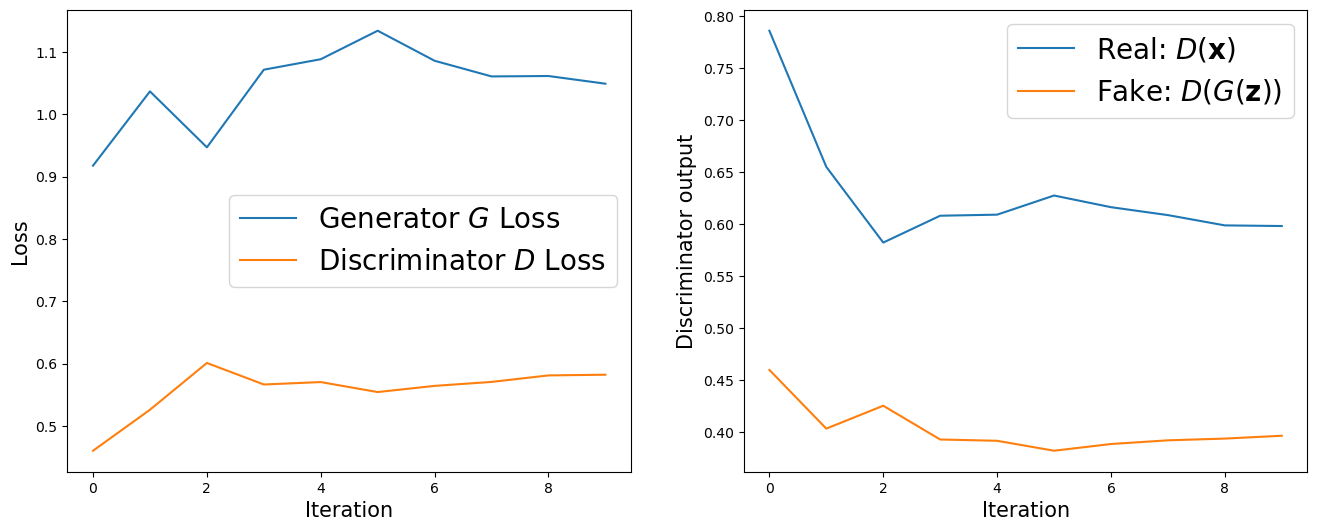

In [44]:
fig = plt.figure(figsize=(16, 6))

# Plot losses

ax = fig.add_subplot(1, 2, 1)
plt.plot(all_generator_losses, label = "Generator $G$ Loss")
half_discriminator_losses = [all_discriminator_loss/2 for all_discriminator_loss in all_discriminator_losses]
plt.plot(half_discriminator_losses, label = 'Discriminator $D$ Loss')
plt.legend(fontsize=20)
ax.set_xlabel("Iteration", size=15)
ax.set_ylabel("Loss", size=15)

# Plot outputs of discriminator

ax = fig.add_subplot(1, 2, 2)
plt.plot(all_discriminator_real, label=r'Real: $D(\mathbf{x})$')
plt.plot(all_discriminator_fake, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size = 15)
ax.set_ylabel('Discriminator output', size=15)
plt.show()

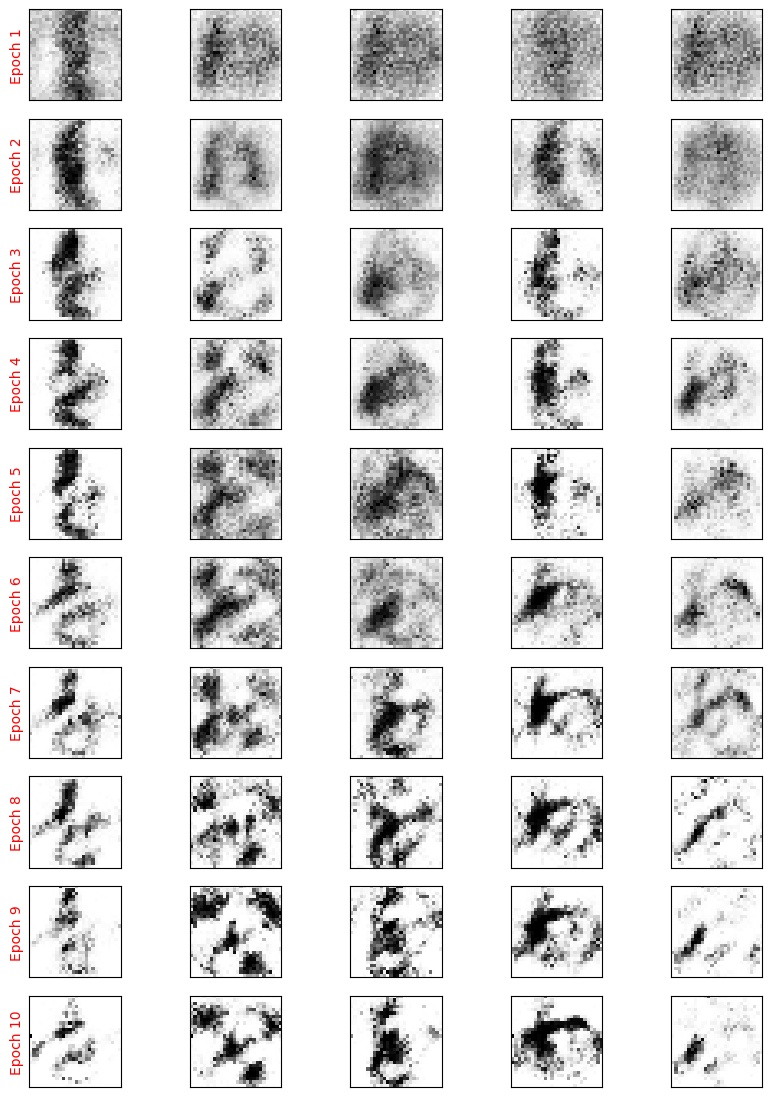

In [45]:
selected_epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
fig = plt.figure(figsize=(10, 14))
for i, e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(10, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation = 90,
                size = 10,
                color = 'red',
                horizontalalignment = 'right',
                verticalalignment = 'center',
                transform = ax.transAxes
            )

        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')

plt.show()